# Plots for the 2MDM analysis

In [17]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from auxPlots import columnsDict, colorDict, defaultPars
from scipy.interpolate import griddata
import itertools

pd.option_context('display.max_columns', None)
pd.option_context('display.max_rows', None)

pd.options.mode.chained_assignment = None #Disable copy warnings
plt.rcParams.update(defaultPars) #Figure resolution

#### Get data in pcl format and print all columns names

In [18]:
#Merge with SModelS DataFrame
pclFiles = ['../data/smodels_results.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
dataDF.set_index('filename',drop=True,inplace=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['mChi', 'mS', 'mZp', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'gchi', 'gq', 'sina', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'CombinedRes', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'ExptRes.result0.maxcond', 'ExptRes.result0.theory prediction (fb)', 'ExptRes.result0.upper limit (fb)', 'ExptRes.result0.expected upper limit (fb)', 'ExptRes.result0.TxNames', 'ExptRes.result0.Mass (GeV)', 

#### Filter couplings

In [19]:
gchi = np.sqrt(2)
gq = 0.25
sina = 0.25
dataDF = dataDF[(np.abs(dataDF['gchi']-gchi) < 0.001) & (dataDF['gq'] == gq) & (dataDF['sina'] == sina)]

#### Set r = 0 for points with no results 

In [20]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

### Split dataframe by analysis ID

In [21]:
# Get ExptRes columns and group according to ExptRes attribute
expResCols = np.array(sorted([c for c in dataDF.columns if 'ExptRes.' in c],key = lambda c: c.split('.')[-1]))
expCols = itertools.groupby(expResCols, key = lambda c: c.split('.')[-1])

# Get all analyses
idCols = np.array([c for c in dataDF.columns if 'AnalysisID' in c])
analysis = sorted(dataDF[idCols].stack().drop_duplicates().tolist())

# Merge all common ExptRes columns into single columns containing a list of results
newDataDF = dataDF.copy()
for key,group in expCols:
    g = list(group)
    newCol = f'ExptRes.result.{key}'
    newDataDF[newCol] = newDataDF[g].values.tolist()
    newDataDF.drop(columns=g,inplace=True)


# Now explode each list of values into distinct rows
expResColsNew = np.array(sorted([c for c in newDataDF.columns if 'ExptRes.' in c],key = lambda c: c.split('.')[-1]))
newDataDFexp = newDataDF.explode(list(expResColsNew))

# Finally group using analsysis IDs
anaGroups = newDataDFexp.groupby(by=['ExptRes.result.AnalysisID'])

In [22]:
anaDict = {ana[0] : anadf for ana,anadf in anaGroups}

#### Add combined analysis

In [23]:
# Create from CombinedRes dictionary:
dataCombinedDF = pd.DataFrame.from_dict([x[0] for x in dataDF[['CombinedRes']].dropna().squeeze()])
# Set index to match dataDF
dataCombinedDF.set_index(dataDF[~dataDF['CombinedRes'].isna()].index,inplace=True)
# Rename columns to match the standard naming
dataCombinedDF.rename(columns = {c : 'ExptRes.result.%s' %c for c in dataCombinedDF.columns.tolist()},inplace=True)
# Add non-exptres columns from dataDF:
dataCombinedDF = pd.concat([dataCombinedDF,dataDF[~dataDF['CombinedRes'].isna()].drop(columns=expResCols).drop(columns='CombinedRes')],axis=1)
# dataCombinedDF


In [24]:
anaDict['CombinedAna'] = dataCombinedDF

### Keep only the MET searches

In [25]:
metAna = ['CMS-EXO-20-004','ATLAS-EXOT-2018-06',
          'ATLAS-SUSY-2018-22-multibin','CombinedAna']
metDict = {ana : anadf for ana,anadf in anaDict.items() if ana in metAna}

#### Create legend for plots for excluded points

In [26]:
legendsDict = {ana: ana.replace('-multibin','') for ana in metDict}
legendsDict['CombinedAna'] = 'ATLAS-SUSY-2018-22'+'\n'+'+ CMS-EXO-20-004'
legendsDict['ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004'] = legendsDict['CombinedAna']


# Plot Results

/tmp/ipykernel_39402/835415223.py:18: UserWarning: No contour levels were found within the data range.
  cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[ana],linestyles='dashed')


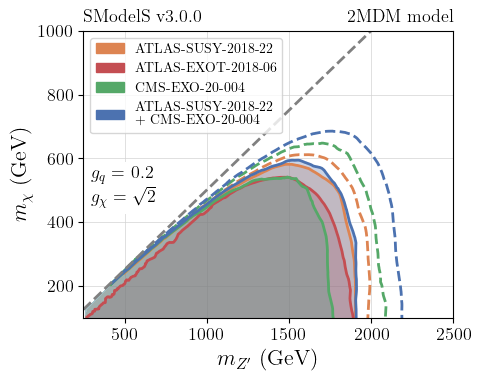

In [29]:
legends = []

# Sort analyses by length of name and then length of points
for ana,anadf in sorted(metDict.items(), key = lambda x: (len(x[0]),len(x[1])),reverse=True):
    x = anadf['mZp']
    y = anadf['mChi']
    # sc = plt.scatter(x,y,s=60, color=colorDict[ana], label=legendsDict[ana], alpha=0.7)
    pts = np.array([y for y in itertools.product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
    rPts = griddata(list(zip(x,y)),anadf['ExptRes.result.r'],pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[ana])
    plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.3, colors=colorDict[ana])

    rPts = griddata(list(zip(x,y)),anadf['ExptRes.result.r_expected'],pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[ana],linestyles='dashed')


    legends.append(mpatches.Patch(color=colorDict[ana], label=legendsDict[ana]))

plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')

plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
textstr = '\n'.join((
    r'$g_q =$ %1.1f' %gq, 
    r'$g_{\chi} = \sqrt{2}$'))

plt.text(0.02,0.4,textstr,
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)

plt.xlim(250,2500)
plt.ylim(100, 1000)

plt.legend(handles=legends, loc='upper left')
plt.tight_layout()
plt.savefig('./figures/monojet-combined-anas2.png')
plt.show()